In [1]:
import pandas as pd
import matplotlib.pyplot as plt

pd.set_option('display.max_columns', 60)
pd.set_option('display.max_rows', 60)
pd.set_option('mode.chained_assignment',  None)

plt.rc('font',family='malgun gothic')

# 국가교통 데이터 오픈마켓
bus_info_data_by_day = pd.read_csv('./data/대전시_버스_일일_정보_데이터.csv', sep = "|") # 대전시 버스 일일 정보 데이터
bus_speed_data = pd.read_csv('./data/대전시_버스_통행_속도_데이터.csv', sep = "|") # 대전시 버스 통행 속도 데이터
bus_route_statistic_data = pd.read_csv('./data/대전시_버스_노선_운행_통계_데이터.csv', sep = "|") # 대전시 버스 노선 운행 통계 데이터
bus_card_data = pd.read_csv('./data/대전시_버스_교통카드거래_이력_데이터.csv', sep = "|") # 대전시 버스 카드 거래 이력 데이터
speed_comparison_data = pd.read_csv('./data/대전시_버스전용차로_승용차구간_속도비교_데이터.csv', sep = "|") # 대전시 버스전용차로 승용차구간 속도비교 데이터

bus_info_data_by_day.drop(labels = ['ETL_TYPE','ETL_DATE'], axis =  1, inplace = True)
bus_speed_data.drop(labels = ['ETL_TYPE','ETL_DATE'], axis =  1, inplace = True)
bus_route_statistic_data.drop(labels = ['ETL_TYPE','ETL_DATE'], axis =  1, inplace = True)
bus_card_data.drop(labels = ['ETL_TYPE','ETL_DATE'], axis =  1, inplace = True)

# 대전 교통 빅데이터 플랫폼
route_curve = pd.read_csv('./data/route_curve.csv', encoding = 'cp949')
route_curve = route_curve.iloc[:,:5]

# 공공데이터포털
getrouteinfoall = pd.read_csv('./data/getRouteInfoAll.csv', encoding = 'cp949', index_col = 0) # 전체 노선 기본정보 조회
getstationbyrouteall = pd.read_csv('./data/getStationByRouteAll.csv', encoding = 'cp949', index_col = 0) # 전체노선별경유정류소 정보 조회

# 정류장 데이터
bus_sttn = pd.read_csv('./data/bus_sttn.csv')

# 스마트카드 데이터
smart_card_data = pd.read_csv('./data/smart_card_data.csv')

In [2]:
def smart_card_preprocessing(exdata): # 스마트카드 데이터 전처리
    exdata = exdata[exdata['GETOFF_BUS_STTN_ID']!='~      '] # 하차 태그 없는 데이터 제거
    exdata['GETON_TM'] = exdata['GETON_TM'].apply(lambda x: str(x).zfill(6)) # GETON_TM 컬럼 날짜형식으로 변환하기 위해 자릿수 맞춰주기
    
    # datetime 형식으로 변환 및 새로운 column 생성
    exdata['GETON_DATETIME'] = pd.to_datetime(exdata['GETON_YMD'].astype(str) + exdata['GETON_TM'].astype(str), format = '%Y%m%d%H%M%S')
    exdata['GETOFF_DATETIME'] = pd.to_datetime(exdata['GETOFF_YMD'].astype(str) + exdata['GETOFF_TM'].astype(str), format = '%Y%m%d%H%M%S', errors = 'coerce')
    
    # 여러명이 탄 경우 제거
    exdata = exdata[exdata['YSR_CNT']==1]
    
    # 지선, 간선 버스만 필터링
    exdata = exdata[exdata['TR_MEANS_TYPE'].isin([676, 675])]
    
    # 사용한 행 제거
    exdata.drop(labels = ['GETON_YMD','GETON_TM','GETOFF_YMD','GETOFF_TM'], axis = 1, inplace = True)
    # 필요없는 행 제거
    exdata.drop(labels = ['SERIAL_NO', 'DRVN_START_YMD','DRVN_START_TM','DRVR_ID','GETON_CALC_YMD','GETOFF_CALC_YMD','ETL_TYPE','ETL_DATE'], axis = 1, inplace = True)
    exdata['DAY'] = exdata['GETON_DATETIME'].dt.day

    return exdata

In [3]:
df = smart_card_data.copy()
df = smart_card_preprocessing(df)
# df[df['TR_MEANS_TYPE'].isin([676, 675])]

In [4]:
df = df[df['TR_MEANS_TYPE'].isin([676, 675])]

In [5]:
df_0425 = df[df['DAY']==25]
df_0425.drop(labels = ['DAY'], axis = 1, inplace = True)
display(df_0425.head(3))
print(df_0425.shape)

,CARD_NO,TRANSACTION_ID,TR_MEANS_TYPE,TRANSF_CNT,BUS_ROUTE_ID,BUS_CO_ID,BUS_CAR_ID,USR_TYPE,GETON_BUS_STTN_ID,GETOFF_BUS_STTN_ID,YSR_CNT,GETON_PAY,GETOFF_PAY,GETON_DATETIME,GETOFF_DATETIME
169539,734471053,6,675,0,30300059,130010004,130752270,1,8006006,8001930,1,1250,0,2022-04-25 19:19:47,2022-04-25 19:38:02
169540,661607970,8,676,0,30300070,130010004,130752603,1,8002794,8002155,1,1250,0,2022-04-25 07:53:58,2022-04-25 08:16:20
169541,706749254,19,675,0,30300079,130010009,130759123,1,8001721,8002802,1,1250,0,2022-04-25 08:07:51,2022-04-25 08:39:44


(276952, 15)


In [6]:
bus_route_counts_df = pd.DataFrame({'BUS_ROUTE_ID': df_0425['BUS_ROUTE_ID'].value_counts().index, 'COUNT': df_0425['BUS_ROUTE_ID'].value_counts().values})
bus_route_counts_df = bus_route_counts_df.sort_values('COUNT', ascending = False).head(10)

In [7]:
getrouteinfoall_df = getrouteinfoall[['ROUTE_CD','ROUTE_NO']]
merged_data =bus_route_counts_df.merge(getrouteinfoall_df, left_on = 'BUS_ROUTE_ID', right_on = 'ROUTE_CD')

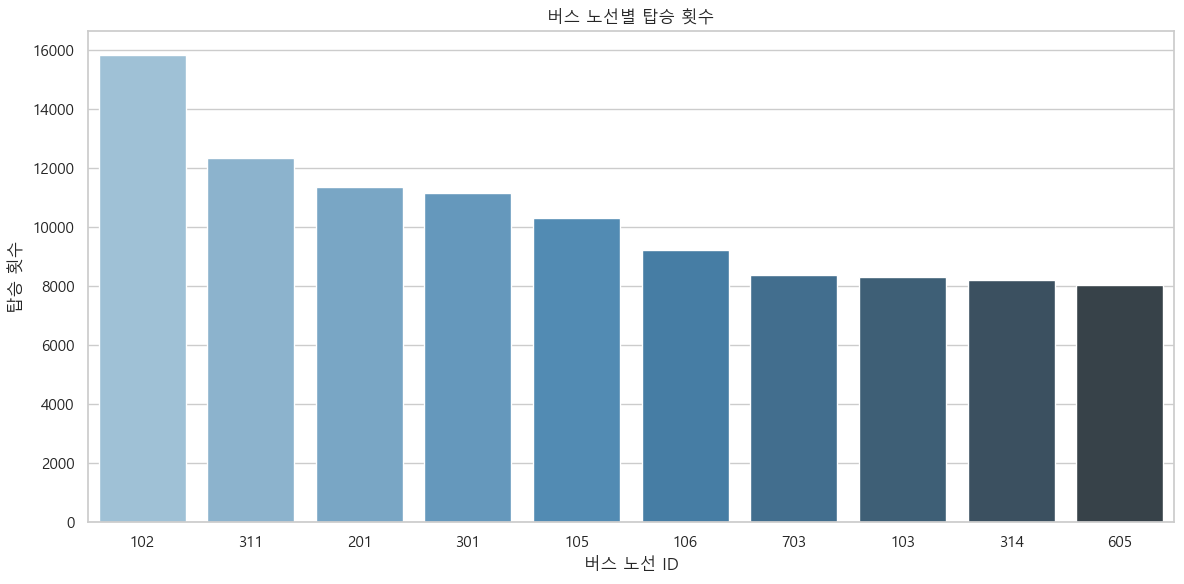

In [8]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style="whitegrid")

plt.figure(figsize=(12, 6))
plt.rc('font',family='malgun gothic')
sns.barplot(x='ROUTE_NO', y='COUNT', data=merged_data, palette='Blues_d')
plt.xlabel('버스 노선 ID')
plt.ylabel('탑승 횟수')
plt.title('버스 노선별 탑승 횟수')
plt.xticks(rotation 
           = 0)
plt.tight_layout()
plt.show()


## 노선별 시각화

### 30300002 [2]

In [9]:
## ROUTE_CD = 30300002의 버스 노선 번호 : 2
# getrouteinfoall[getrouteinfoall['ROUTE_CD']==30300002]['ROUTE_NO']

In [10]:
# ROUTE_CD = 30300002의 전체 경로
route_30300002 = getstationbyrouteall[getstationbyrouteall['ROUTE_CD']==30300002]
route_30300002.head(2)

,BUSSTOP_ENG_NM,BUSSTOP_NM,BUSSTOP_SEQ,BUSSTOP_TP,BUS_NODE_ID,BUS_STOP_ID,GPS_LATI,GPS_LONG,ROAD_NM,ROAD_NM_ADDR,ROUTE_CD,TOTAL_DIST
106,Bongsan-dong,봉산동기점,1,1,8001783,44490,36.448254,127.384605,봉산로,,30300002,72
107,Gujeuk-dong,송강마을아파트,2,,8001178,44790,36.437572,127.385760,봉산로,,30300002,1478


In [11]:
# 정류장 유형(1:기점 2: 종점 3: 일반)
route_30300002[route_30300002['BUSSTOP_TP']=='1']

,BUSSTOP_ENG_NM,BUSSTOP_NM,BUSSTOP_SEQ,BUSSTOP_TP,BUS_NODE_ID,BUS_STOP_ID,GPS_LATI,GPS_LONG,ROAD_NM,ROAD_NM_ADDR,ROUTE_CD,TOTAL_DIST
106,Bongsan-dong,봉산동기점,1,1,8001783,44490,36.448254,127.384605,봉산로,,30300002,72


In [12]:
# # 2번 버스 노선 시각화
# import pydeck as pdk

# layer = pdk.Layer(
#     "ScatterplotLayer",
#     data=route_30300002,
#     get_position=["GPS_LONG", "GPS_LATI"],
#     get_color=[0, 255, 255, 150],  # RGB 및 투명도
#     get_radius=100,
#     pickable=True,
# )
# # PyDeck 맵 생성
# view_state = pdk.ViewState(latitude=36.35, longitude=127.38, zoom=11)
# r = pdk.Deck(layers=[layer], initial_view_state=view_state)

# r

### 30300037 [102]

In [13]:
# ROUTE_CD = 30300037의 버스 노선 번호 : 102
# getrouteinfoall[getrouteinfoall['ROUTE_CD']==30300037]['ROUTE_NO']

In [14]:
# ROUTE_CD = 30300037의 전체 경로
route_30300037 = getstationbyrouteall[getstationbyrouteall['ROUTE_CD']==30300037]
route_30300037.head(2)

,BUSSTOP_ENG_NM,BUSSTOP_NM,BUSSTOP_SEQ,BUSSTOP_TP,BUS_NODE_ID,BUS_STOP_ID,GPS_LATI,GPS_LONG,ROAD_NM,ROAD_NM_ADDR,ROUTE_CD,TOTAL_DIST
2189,Sutonggol,수통골기점지,1,1,8002077,41650,36.346115,127.29533,수통골로,,30300037,36
2190,Hwasan-ri,수통골삼거리,2,,8003003,41670,36.348057,127.29619,,,30300037,332


In [15]:
# 정류장 유형(1:기점 2: 종점 3: 일반)
route_30300037[route_30300037['BUSSTOP_TP']=='2']

,BUSSTOP_ENG_NM,BUSSTOP_NM,BUSSTOP_SEQ,BUSSTOP_TP,BUS_NODE_ID,BUS_STOP_ID,GPS_LATI,GPS_LONG,ROAD_NM,ROAD_NM_ADDR,ROUTE_CD,TOTAL_DIST
2236,Daejeon Station East Square,대전역동광장,48,2,8005504,11410,36.33353,127.43734,,,30300037,21410


In [16]:
# # 102번 버스 노선 시각화
# import pydeck as pdk

# layer = pdk.Layer(
#     "ScatterplotLayer",
#     data=route_30300037,
#     get_position=["GPS_LONG", "GPS_LATI"],
#     get_color=[0, 255, 255, 150],  # RGB 및 투명도
#     get_radius=100,
#     pickable=True,
# )
# # PyDeck 맵 생성
# view_state = pdk.ViewState(latitude=36.35, longitude=127.38, zoom=12)
# r = pdk.Deck(layers=[layer], initial_view_state=view_state)

# r

### 30300038 [103]

In [17]:
# # ROUTE_CD = 30300038의 버스 노선 번호 : 103
# getrouteinfoall[getrouteinfoall['ROUTE_CD']==30300038]['ROUTE_NO']

In [18]:
# ROUTE_CD = 30300038의 전체 경로
route_30300038 = getstationbyrouteall[getstationbyrouteall['ROUTE_CD']==30300038]
route_30300038.head(2)

,BUSSTOP_ENG_NM,BUSSTOP_NM,BUSSTOP_SEQ,BUSSTOP_TP,BUS_NODE_ID,BUS_STOP_ID,GPS_LATI,GPS_LONG,ROAD_NM,ROAD_NM_ADDR,ROUTE_CD,TOTAL_DIST
2280,Sutonggol,수통골기점지,1,1,8002077,41650,36.346115,127.29533,수통골로,,30300038,36
2281,Hwasan-ri,수통골삼거리,2,,8003003,41670,36.348057,127.29619,,,30300038,332


In [19]:
# 정류장 유형(1:기점 2: 종점 3: 일반)
route_30300038[route_30300038['BUSSTOP_TP']=='2']

,BUSSTOP_ENG_NM,BUSSTOP_NM,BUSSTOP_SEQ,BUSSTOP_TP,BUS_NODE_ID,BUS_STOP_ID,GPS_LATI,GPS_LONG,ROAD_NM,ROAD_NM_ADDR,ROUTE_CD,TOTAL_DIST
2333,Dongchundang,동춘당,54,2,9001553,50960,36.36591,127.439125,동춘당로,,30300038,24168


In [20]:
# # 102번 버스 노선 시각화
# import pydeck as pdk

# layer = pdk.Layer(
#     "ScatterplotLayer",
#     data=route_30300038,
#     get_position=["GPS_LONG", "GPS_LATI"],
#     get_color=[0, 255, 255, 150],  # RGB 및 투명도
#     get_radius=100,
#     pickable=True,
# )
# # PyDeck 맵 생성
# view_state = pdk.ViewState(latitude=36.35, longitude=127.38, zoom=12)
# r = pdk.Deck(layers=[layer], initial_view_state=view_state)

# r

### 30300040 [105]

In [21]:
# # ROUTE_CD = 30300040의 버스 노선 번호 : 105
# getrouteinfoall[getrouteinfoall['ROUTE_CD']==30300040]['ROUTE_NO']

In [22]:
# ROUTE_CD = 30300040의 전체 경로
route_30300040 = getstationbyrouteall[getstationbyrouteall['ROUTE_CD']==30300040]
route_30300040.head(2)

,BUSSTOP_ENG_NM,BUSSTOP_NM,BUSSTOP_SEQ,BUSSTOP_TP,BUS_NODE_ID,BUS_STOP_ID,GPS_LATI,GPS_LONG,ROAD_NM,ROAD_NM_ADDR,ROUTE_CD,TOTAL_DIST
2459,Chungnam National University,충대농대종점,1,1,8002736,42740,36.365704,127.352036,,,30300040,13
2460,Hanbit Apts.,한빛아파트,2,,8002941,42720,36.362860,127.353004,,,30300040,347


In [23]:
# 정류장 유형(1:기점 2: 종점 3: 일반)
route_30300040[route_30300040['BUSSTOP_TP']=='2']

,BUSSTOP_ENG_NM,BUSSTOP_NM,BUSSTOP_SEQ,BUSSTOP_TP,BUS_NODE_ID,BUS_STOP_ID,GPS_LATI,GPS_LONG,ROAD_NM,ROAD_NM_ADDR,ROUTE_CD,TOTAL_DIST
2504,Samho Apt.,삼호아파트,46,2,9001891,51560,36.35399,127.44925,비래서로,,30300040,20079


In [24]:
# 102번 버스 노선 시각화
import pydeck as pdk

layer = pdk.Layer(
    "ScatterplotLayer",
    data=route_30300040,
    get_position=["GPS_LONG", "GPS_LATI"],
    get_color=[0, 255, 255, 150],  # RGB 및 투명도
    get_radius=100,
    pickable=True,
)
# PyDeck 맵 생성
view_state = pdk.ViewState(latitude=36.35, longitude=127.38, zoom=12)
r = pdk.Deck(layers=[layer], initial_view_state=view_state)

r

{
  "initialViewState": {
    "latitude": 36.35,
    "longitude": 127.38,
    "zoom": 12
  },
  "layers": [
    {
      "@@type": "ScatterplotLayer",
      "data": [
        {
          "BUSSTOP_ENG_NM": "Chungnam National University",
          "BUSSTOP_NM": "\ucda9\ub300\ub18d\ub300\uc885\uc810",
          "BUSSTOP_SEQ": 1,
          "BUSSTOP_TP": "1",
          "BUS_NODE_ID": 8002736,
          "BUS_STOP_ID": 42740,
          "GPS_LATI": 36.365704,
          "GPS_LONG": 127.352036,
          "ROAD_NM": " ",
          "ROAD_NM_ADDR": " ",
          "ROUTE_CD": 30300040,
          "TOTAL_DIST": 13
        },
        {
          "BUSSTOP_ENG_NM": "Hanbit Apts.",
          "BUSSTOP_NM": "\ud55c\ube5b\uc544\ud30c\ud2b8",
          "BUSSTOP_SEQ": 2,
          "BUSSTOP_TP": " ",
          "BUS_NODE_ID": 8002941,
          "BUS_STOP_ID": 42720,
          "GPS_LATI": 36.36286,
          "GPS_LONG": 127.353004,
          "ROAD_NM": " ",
          "ROAD_NM_ADDR": " ",
          "ROUTE_CD": 30300040,
          "TOTAL_DIST": 347
        },
        {
          "BUSSTOP_ENG_NM": "Chungnam National University, College of Agricultural College Entrance",
          "BUSSTOP_NM": "\ucda9\ub300\ub18d\ub300\uc785\uad6c",
          "BUSSTOP_SEQ": 3,
          "BUSSTOP_TP": " ",
          "BUS_NODE_ID": 8002735,
          "BUS_STOP_ID": 42710,
          "GPS_LATI": 36.36042,
          "GPS_LONG": 127.35253,
          "ROAD_NM": " ",
          "ROAD_NM_ADDR": " ",
          "ROUTE_CD": 30300040,
          "TOTAL_DIST": 728
        },
        {
          "BUSSTOP_ENG_NM": "Gung-dong",
          "BUSSTOP_NM": "\uad81\ub3d9",
          "BUSSTOP_SEQ": 4,
          "BUSSTOP_TP": " ",
          "BUS_NODE_ID": 8001193,
          "BUS_STOP_ID": 42700,
          "GPS_LATI": 36.360806,
          "GPS_LONG": 127.34954,
          "ROAD_NM": "\ub300\ud559\ub85c",
          "ROAD_NM_ADDR": " ",
          "ROUTE_CD": 30300040,
          "TOTAL_DIST": 1003
        },
        {
          "BUSSTOP_ENG_NM": "Chungnam National University",
          "BUSSTOP_NM": "\ucda9\ub0a8\ub300\ud559\uad50",
          "BUSSTOP_SEQ": 5,
          "BUSSTOP_TP": " ",
          "BUS_NODE_ID": 8002721,
          "BUS_STOP_ID": 42600,
          "GPS_LATI": 36.36156,
          "GPS_LONG": 127.34412,
          "ROAD_NM": " ",
          "ROAD_NM_ADDR": " ",
          "ROUTE_CD": 30300040,
          "TOTAL_DIST": 1580
        },
        {
          "BUSSTOP_ENG_NM": "Hanjin Officetel(Studio Apt.)",
          "BUSSTOP_NM": "\ud55c\uc9c4\uc624\ud53c\uc2a4\ud154",
          "BUSSTOP_SEQ": 6,
          "BUSSTOP_TP": " ",
          "BUS_NODE_ID": 8002960,
          "BUS_STOP_ID": 41340,
          "GPS_LATI": 36.356445,
          "GPS_LONG": 127.342064,
          "ROAD_NM": " ",
          "ROAD_NM_ADDR": " ",
          "ROUTE_CD": 30300040,
          "TOTAL_DIST": 2177
        },
        {
          "BUSSTOP_ENG_NM": "---",
          "BUSSTOP_NM": "\uc720\uc131\uc628\ucc9c\uc5ed1\ubc88\ucd9c\uad6c",
          "BUSSTOP_SEQ": 7,
          "BUSSTOP_TP": " ",
          "BUS_NODE_ID": 8007564,
          "BUS_STOP_ID": 46850,
          "GPS_LATI": 36.352802,
          "GPS_LONG": 127.34395,
          "ROAD_NM": " ",
          "ROAD_NM_ADDR": " ",
          "ROUTE_CD": 30300040,
          "TOTAL_DIST": 2715
        },
        {
          "BUSSTOP_ENG_NM": "Mannyeongyo(bridge)",
          "BUSSTOP_NM": "\ub9cc\ub144\uad50",
          "BUSSTOP_SEQ": 8,
          "BUSSTOP_TP": " ",
          "BUS_NODE_ID": 8001596,
          "BUS_STOP_ID": 41370,
          "GPS_LATI": 36.351994,
          "GPS_LONG": 127.34679,
          "ROAD_NM": "\uacc4\ub8e1\ub85c",
          "ROAD_NM_ADDR": " ",
          "ROUTE_CD": 30300040,
          "TOTAL_DIST": 2985
        },
        {
          "BUSSTOP_ENG_NM": "Daejeon Metropolitan Express Transit Corporation",
          "BUSSTOP_NM": "\ub300\uc804\uad50\ud1b5\uacf5\uc0ac",
          "BUSSTOP_SEQ": 9,
          "BUSSTOP_TP": " ",
          "BUS_NODE_ID": 8001389,
          

### 30300041 [106]

In [25]:
# # ROUTE_CD = 30300041의 버스 노선 번호 : 106
# getrouteinfoall[getrouteinfoall['ROUTE_CD']==30300041]['ROUTE_NO']

In [26]:
# ROUTE_CD = 30300041의 전체 경로
route_30300041 = getstationbyrouteall[getstationbyrouteall['ROUTE_CD']==30300041]
route_30300041.head(2)

,BUSSTOP_ENG_NM,BUSSTOP_NM,BUSSTOP_SEQ,BUSSTOP_TP,BUS_NODE_ID,BUS_STOP_ID,GPS_LATI,GPS_LONG,ROAD_NM,ROAD_NM_ADDR,ROUTE_CD,TOTAL_DIST
2544,Mokwon University Front Gate,목원대학교,1,1,8001641,33230,36.329674,127.338196,도안동로,,30300041,105
2545,Heungdo Elementary School,흥도초등학교,2,,8070030,41810,36.333813,127.338260,,,30300041,509


In [27]:
# 정류장 유형(1:기점 2: 종점 3: 일반)
route_30300041[route_30300041['BUSSTOP_TP']=='2']

,BUSSTOP_ENG_NM,BUSSTOP_NM,BUSSTOP_SEQ,BUSSTOP_TP,BUS_NODE_ID,BUS_STOP_ID,GPS_LATI,GPS_LONG,ROAD_NM,ROAD_NM_ADDR,ROUTE_CD,TOTAL_DIST
2584,Birae-dong Terminal,비래동종점,41,2,9001803,51590,36.360332,127.44997,우암로,,30300041,18863


In [29]:
# # 106번 버스 노선 시각화
# import pydeck as pdk

# layer = pdk.Layer(
#     "ScatterplotLayer",
#     data=route_30300041,
#     get_position=["GPS_LONG", "GPS_LATI"],
#     get_color=[0, 255, 255, 150],  # RGB 및 투명도
#     get_radius=100,
#     pickable=True,
# )
# # PyDeck 맵 생성
# view_state = pdk.ViewState(latitude=36.35, longitude=127.38, zoom=12)
# r = pdk.Deck(layers=[layer], initial_view_state=view_state)

# r

### 30300051 [201]

In [30]:
# # ROUTE_CD = 30300051의 버스 노선 번호 : 201
# getrouteinfoall[getrouteinfoall['ROUTE_CD']==30300051]['ROUTE_NO']

In [31]:
# ROUTE_CD = 30300051의 전체 경로
route_30300051 = getstationbyrouteall[getstationbyrouteall['ROUTE_CD']==30300051]
route_30300051.head(2)

,BUSSTOP_ENG_NM,BUSSTOP_NM,BUSSTOP_SEQ,BUSSTOP_TP,BUS_NODE_ID,BUS_STOP_ID,GPS_LATI,GPS_LONG,ROAD_NM,ROAD_NM_ADDR,ROUTE_CD,TOTAL_DIST
3331,Wonnae Public Garage,원내동공영차고지,1,1,8002355,40080,36.29267,127.318375,계백로,계백로,30300051,65
3332,Seodaejeon I.C.,서대전IC,2,,8001946,40100,36.29400,127.318390,진잠로,,30300051,262


In [32]:
# 정류장 유형(1:기점 2: 종점 3: 일반)
route_30300051[route_30300051['BUSSTOP_TP']=='2']

,BUSSTOP_ENG_NM,BUSSTOP_NM,BUSSTOP_SEQ,BUSSTOP_TP,BUS_NODE_ID,BUS_STOP_ID,GPS_LATI,GPS_LONG,ROAD_NM,ROAD_NM_ADDR,ROUTE_CD,TOTAL_DIST
3379,Birae Check Point,비래검문소,49,2,9007010,53220,36.355915,127.444664,동서대로,,30300051,19262


In [34]:
# # 201번 버스 노선 시각화
# import pydeck as pdk

# layer = pdk.Layer(
#     "ScatterplotLayer",
#     data=route_30300051,
#     get_position=["GPS_LONG", "GPS_LATI"],
#     get_color=[0, 255, 255, 150],  # RGB 및 투명도
#     get_radius=100,
#     pickable=True,
# )
# # PyDeck 맵 생성
# view_state = pdk.ViewState(latitude=36.35, longitude=127.38, zoom=11)
# r = pdk.Deck(layers=[layer], initial_view_state=view_state)

# r

### 30300054 [301]

In [35]:
# # ROUTE_CD = 30300054의 버스 노선 번호 : 301
# getrouteinfoall[getrouteinfoall['ROUTE_CD']==30300054]['ROUTE_NO']

In [36]:
# ROUTE_CD = 30300054의 전체 경로
route_30300054 = getstationbyrouteall[getstationbyrouteall['ROUTE_CD']==30300054]
route_30300054.head(2)

,BUSSTOP_ENG_NM,BUSSTOP_NM,BUSSTOP_SEQ,BUSSTOP_TP,BUS_NODE_ID,BUS_STOP_ID,GPS_LATI,GPS_LONG,ROAD_NM,ROAD_NM_ADDR,ROUTE_CD,TOTAL_DIST
3648,Bongsan-dong,봉산동기점,1,1,8001783,44490,36.448254,127.384605,봉산로,,30300054,72
3649,"Bongsan 3(sam)-tong, Hyeopjin Transport Corpor...",협진운수,2,,8001780,44480,36.445457,127.383920,금남구즉로,,30300054,397


In [37]:
# 정류장 유형(1:기점 2: 종점 3: 일반)
route_30300054[route_30300054['BUSSTOP_TP']=='2']

,BUSSTOP_ENG_NM,BUSSTOP_NM,BUSSTOP_SEQ,BUSSTOP_TP,BUS_NODE_ID,BUS_STOP_ID,GPS_LATI,GPS_LONG,ROAD_NM,ROAD_NM_ADDR,ROUTE_CD,TOTAL_DIST
3700,---,윗사정삼거리,53,2,9007515,9007515,36.29234,127.39754,,,30300054,23138


In [39]:
# # 301번 버스 노선 시각화
# import pydeck as pdk

# layer = pdk.Layer(
#     "ScatterplotLayer",
#     data=route_30300054,
#     get_position=["GPS_LONG", "GPS_LATI"],
#     get_color=[0, 255, 255, 150],  # RGB 및 투명도
#     get_radius=100,
#     pickable=True,
# )
# # PyDeck 맵 생성
# view_state = pdk.ViewState(latitude=36.35, longitude=127.38, zoom=10)
# r = pdk.Deck(layers=[layer], initial_view_state=view_state)

# r

### 30300055 [311]

In [41]:
# # ROUTE_CD = 30300055의 버스 노선 번호 : 311
# getrouteinfoall[getrouteinfoall['ROUTE_CD']==30300055]['ROUTE_NO']

In [42]:
# ROUTE_CD = 30300055의 전체 경로
route_30300055 = getstationbyrouteall[getstationbyrouteall['ROUTE_CD']==30300055]
route_30300055.head(2)

,BUSSTOP_ENG_NM,BUSSTOP_NM,BUSSTOP_SEQ,BUSSTOP_TP,BUS_NODE_ID,BUS_STOP_ID,GPS_LATI,GPS_LONG,ROAD_NM,ROAD_NM_ADDR,ROUTE_CD,TOTAL_DIST
3749,---,신대차고지,1,1,8007174,53250,36.40874,127.42173,,,30300055,303
3750,Deulmal,들말,2,,8007175,53260,36.41106,127.42406,,,30300055,690


In [43]:
# 정류장 유형(1:기점 2: 종점 3: 일반)
route_30300055[route_30300055['BUSSTOP_TP']=='2']

,BUSSTOP_ENG_NM,BUSSTOP_NM,BUSSTOP_SEQ,BUSSTOP_TP,BUS_NODE_ID,BUS_STOP_ID,GPS_LATI,GPS_LONG,ROAD_NM,ROAD_NM_ADDR,ROUTE_CD,TOTAL_DIST
3803,---,윗사정삼거리,55,2,9007040,9007040,36.293003,127.399086,,,30300055,24654


In [44]:
# # 311번 버스 노선 시각화
# import pydeck as pdk

# layer = pdk.Layer(
#     "ScatterplotLayer",
#     data=route_30300055,
#     get_position=["GPS_LONG", "GPS_LATI"],
#     get_color=[0, 255, 255, 150],  # RGB 및 투명도
#     get_radius=100,
#     pickable=True,
# )
# # PyDeck 맵 생성
# view_state = pdk.ViewState(latitude=36.35, longitude=127.38, zoom=11)
# r = pdk.Deck(layers=[layer], initial_view_state=view_state)

# r

### 30300087 [703]

In [82]:
# # ROUTE_CD = 30300087의 버스 노선 번호 : 703
# getrouteinfoall[getrouteinfoall['ROUTE_CD']==30300087]['ROUTE_NO']

In [83]:
# ROUTE_CD = 30300087의 전체 경로
route_30300087 = getstationbyrouteall[getstationbyrouteall['ROUTE_CD']==30300087]
route_30300087.head(2)

,BUSSTOP_ENG_NM,BUSSTOP_NM,BUSSTOP_SEQ,BUSSTOP_TP,BUS_NODE_ID,BUS_STOP_ID,GPS_LATI,GPS_LONG,ROAD_NM,ROAD_NM_ADDR,ROUTE_CD,TOTAL_DIST
6452,Sintanjin Starting Point,신탄진기점지,1,1,8005503,51650,36.451550,127.417510,,,30300087,27
6453,---,금강엑슬루타워정문,2,,8007252,53370,36.449993,127.418785,,,30300087,805


In [84]:
# 정류장 유형(1:기점 2: 종점 3: 일반)
route_30300087[route_30300087['BUSSTOP_TP']=='2']

,BUSSTOP_ENG_NM,BUSSTOP_NM,BUSSTOP_SEQ,BUSSTOP_TP,BUS_NODE_ID,BUS_STOP_ID,GPS_LATI,GPS_LONG,ROAD_NM,ROAD_NM_ADDR,ROUTE_CD,TOTAL_DIST
6509,---,정림동종점,58,2,8007448,35650,36.291374,127.36121,,,30300087,27322


In [95]:
line_layer = pdk.Layer(
    'LineLayer',
    data = route_30300087.iloc[:58],
    get_source_position='[GPS_LONG, GPS_LATI]',
    get_target_position='[GPS_LONG, GPS_LATI]',
    get_color=[255, 255, 0],  # 선의 색상을 초록색으로 설정
    get_width=5,  # 선의 두께
    pickable=True,  # 선택 가능하도록 설정
    auto_highlight=True  # 마우스 오버 시 강조 표시
)

# 초기 뷰 스테이트 설정
center = [127.38, 36.35]  # 중심 위치 좌표
view_state = pdk.ViewState(
    longitude=center[0],
    latitude=center[1],
    zoom=10
)

# Deck 생성
r = pdk.Deck(layers=[line_layer], initial_view_state=view_state)
r

{
  "initialViewState": {
    "latitude": 36.35,
    "longitude": 127.38,
    "zoom": 10
  },
  "layers": [
    {
      "@@type": "LineLayer",
      "autoHighlight": true,
      "data": [
        {
          "BUSSTOP_ENG_NM": "Sintanjin Starting Point",
          "BUSSTOP_NM": "\uc2e0\ud0c4\uc9c4\uae30\uc810\uc9c0",
          "BUSSTOP_SEQ": 1,
          "BUSSTOP_TP": "1",
          "BUS_NODE_ID": 8005503,
          "BUS_STOP_ID": 51650,
          "GPS_LATI": 36.45155,
          "GPS_LONG": 127.41751,
          "ROAD_NM": " ",
          "ROAD_NM_ADDR": " ",
          "ROUTE_CD": 30300087,
          "TOTAL_DIST": 27
        },
        {
          "BUSSTOP_ENG_NM": "---",
          "BUSSTOP_NM": "\uae08\uac15\uc5d1\uc2ac\ub8e8\ud0c0\uc6cc\uc815\ubb38",
          "BUSSTOP_SEQ": 2,
          "BUSSTOP_TP": " ",
          "BUS_NODE_ID": 8007252,
          "BUS_STOP_ID": 53370,
          "GPS_LATI": 36.449993,
          "GPS_LONG": 127.418785,
          "ROAD_NM": " ",
          "ROAD_NM_ADDR": " ",
          "ROUTE_CD": 30300087,
          "TOTAL_DIST": 805
        },
        {
          "BUSSTOP_ENG_NM": "Geumgang ExlluTower Apts.",
          "BUSSTOP_NM": "\uae08\uac15\uc5d1\uc2ac\ub8e8\ud0c0\uc6cc",
          "BUSSTOP_SEQ": 3,
          "BUSSTOP_TP": " ",
          "BUS_NODE_ID": 8002847,
          "BUS_STOP_ID": 51660,
          "GPS_LATI": 36.449306,
          "GPS_LONG": 127.42087,
          "ROAD_NM": " ",
          "ROAD_NM_ADDR": " ",
          "ROUTE_CD": 30300087,
          "TOTAL_DIST": 1105
        },
        {
          "BUSSTOP_ENG_NM": "Sintanjin Market",
          "BUSSTOP_NM": "\uc2e0\ud0c4\uc9c4\uc2dc\uc7a5",
          "BUSSTOP_SEQ": 4,
          "BUSSTOP_TP": " ",
          "BUS_NODE_ID": 8002131,
          "BUS_STOP_ID": 51700,
          "GPS_LATI": 36.450222,
          "GPS_LONG": 127.42443,
          "ROAD_NM": "\ub300\ub355\ub300\ub85c",
          "ROAD_NM_ADDR": " ",
          "ROUTE_CD": 30300087,
          "TOTAL_DIST": 1447
        },
        {
          "BUSSTOP_ENG_NM": "Sintanjin Station",
          "BUSSTOP_NM": "\uc2e0\ud0c4\uc9c4\uc5ed",
          "BUSSTOP_SEQ": 5,
          "BUSSTOP_TP": " ",
          "BUS_NODE_ID": 8002133,
          "BUS_STOP_ID": 52790,
          "GPS_LATI": 36.449863,
          "GPS_LONG": 127.428955,
          "ROAD_NM": "\uc2e0\ud0c4\uc9c4\ub85c",
          "ROAD_NM_ADDR": " ",
          "ROUTE_CD": 30300087,
          "TOTAL_DIST": 1970
        },
        {
          "BUSSTOP_ENG_NM": "Namgyeong Village",
          "BUSSTOP_NM": "\ub0a8\uacbd\ub9c8\uc744",
          "BUSSTOP_SEQ": 6,
          "BUSSTOP_TP": " ",
          "BUS_NODE_ID": 8001241,
          "BUS_STOP_ID": 51720,
          "GPS_LATI": 36.44464,
          "GPS_LONG": 127.42941,
          "ROAD_NM": "\uc2e0\ud0c4\uc9c4\ub85c",
          "ROAD_NM_ADDR": " ",
          "ROUTE_CD": 30300087,
          "TOTAL_DIST": 2557
        },
        {
          "BUSSTOP_ENG_NM": "Deogam-dong",
          "BUSSTOP_NM": "\ub355\uc554\ub3d9\uc8fc\ubbfc\uc13c\ud130",
          "BUSSTOP_SEQ": 7,
          "BUSSTOP_TP": " ",
          "BUS_NODE_ID": 8001473,
          "BUS_STOP_ID": 52330,
          "GPS_LATI": 36.438053,
          "GPS_LONG": 127.42623,
          "ROAD_NM": "\uc2e0\ud0c4\uc9c4\ub85c",
          "ROAD_NM_ADDR": " ",
          "ROUTE_CD": 30300087,
          "TOTAL_DIST": 3365
        },
        {
          "BUSSTOP_ENG_NM": "Pyeongchon-dong",
          "BUSSTOP_NM": "\ud3c9\ucd0c\ub3d9",
          "BUSSTOP_SEQ": 8,
          "BUSSTOP_TP": " ",
          "BUS_NODE_ID": 8002840,
          "BUS_STOP_ID": 52310,
          "GPS_LATI": 36.435814,
          "GPS_LONG": 127.42541,
          "ROAD_NM": " ",
          "ROAD_NM_ADDR": " ",
          "ROUTE_CD": 30300087,
          "TOTAL_DIST": 3624
        },
        {
          "BUSSTOP_ENG_NM": "Sintanjin Hanil Hospital",
          "BUSSTOP_NM": "\uc2e0\ud0c4\uc9c4\ud55c\uc77c\ubcd1\uc6d0",
          "BUSSTOP_SEQ": 9,
          "BUSSTOP_TP": " ",
          "BUS_NODE_ID": 800

In [85]:
# 703번 버스 노선 시각화
import pydeck as pdk

layer = pdk.Layer(
    "ScatterplotLayer",
    data=route_30300087,
    get_position=["GPS_LONG", "GPS_LATI"],
    get_color=[0, 255, 255, 150],  # RGB 및 투명도
    get_radius=100,
    pickable=True,
)
# PyDeck 맵 생성
view_state = pdk.ViewState(latitude=36.35, longitude=127.38, zoom=11)
r = pdk.Deck(layers=[layer], initial_view_state=view_state)

r

{
  "initialViewState": {
    "latitude": 36.35,
    "longitude": 127.38,
    "zoom": 11
  },
  "layers": [
    {
      "@@type": "ScatterplotLayer",
      "data": [
        {
          "BUSSTOP_ENG_NM": "Sintanjin Starting Point",
          "BUSSTOP_NM": "\uc2e0\ud0c4\uc9c4\uae30\uc810\uc9c0",
          "BUSSTOP_SEQ": 1,
          "BUSSTOP_TP": "1",
          "BUS_NODE_ID": 8005503,
          "BUS_STOP_ID": 51650,
          "GPS_LATI": 36.45155,
          "GPS_LONG": 127.41751,
          "ROAD_NM": " ",
          "ROAD_NM_ADDR": " ",
          "ROUTE_CD": 30300087,
          "TOTAL_DIST": 27
        },
        {
          "BUSSTOP_ENG_NM": "---",
          "BUSSTOP_NM": "\uae08\uac15\uc5d1\uc2ac\ub8e8\ud0c0\uc6cc\uc815\ubb38",
          "BUSSTOP_SEQ": 2,
          "BUSSTOP_TP": " ",
          "BUS_NODE_ID": 8007252,
          "BUS_STOP_ID": 53370,
          "GPS_LATI": 36.449993,
          "GPS_LONG": 127.418785,
          "ROAD_NM": " ",
          "ROAD_NM_ADDR": " ",
          "ROUTE_CD": 30300087,
          "TOTAL_DIST": 805
        },
        {
          "BUSSTOP_ENG_NM": "Geumgang ExlluTower Apts.",
          "BUSSTOP_NM": "\uae08\uac15\uc5d1\uc2ac\ub8e8\ud0c0\uc6cc",
          "BUSSTOP_SEQ": 3,
          "BUSSTOP_TP": " ",
          "BUS_NODE_ID": 8002847,
          "BUS_STOP_ID": 51660,
          "GPS_LATI": 36.449306,
          "GPS_LONG": 127.42087,
          "ROAD_NM": " ",
          "ROAD_NM_ADDR": " ",
          "ROUTE_CD": 30300087,
          "TOTAL_DIST": 1105
        },
        {
          "BUSSTOP_ENG_NM": "Sintanjin Market",
          "BUSSTOP_NM": "\uc2e0\ud0c4\uc9c4\uc2dc\uc7a5",
          "BUSSTOP_SEQ": 4,
          "BUSSTOP_TP": " ",
          "BUS_NODE_ID": 8002131,
          "BUS_STOP_ID": 51700,
          "GPS_LATI": 36.450222,
          "GPS_LONG": 127.42443,
          "ROAD_NM": "\ub300\ub355\ub300\ub85c",
          "ROAD_NM_ADDR": " ",
          "ROUTE_CD": 30300087,
          "TOTAL_DIST": 1447
        },
        {
          "BUSSTOP_ENG_NM": "Sintanjin Station",
          "BUSSTOP_NM": "\uc2e0\ud0c4\uc9c4\uc5ed",
          "BUSSTOP_SEQ": 5,
          "BUSSTOP_TP": " ",
          "BUS_NODE_ID": 8002133,
          "BUS_STOP_ID": 52790,
          "GPS_LATI": 36.449863,
          "GPS_LONG": 127.428955,
          "ROAD_NM": "\uc2e0\ud0c4\uc9c4\ub85c",
          "ROAD_NM_ADDR": " ",
          "ROUTE_CD": 30300087,
          "TOTAL_DIST": 1970
        },
        {
          "BUSSTOP_ENG_NM": "Namgyeong Village",
          "BUSSTOP_NM": "\ub0a8\uacbd\ub9c8\uc744",
          "BUSSTOP_SEQ": 6,
          "BUSSTOP_TP": " ",
          "BUS_NODE_ID": 8001241,
          "BUS_STOP_ID": 51720,
          "GPS_LATI": 36.44464,
          "GPS_LONG": 127.42941,
          "ROAD_NM": "\uc2e0\ud0c4\uc9c4\ub85c",
          "ROAD_NM_ADDR": " ",
          "ROUTE_CD": 30300087,
          "TOTAL_DIST": 2557
        },
        {
          "BUSSTOP_ENG_NM": "Deogam-dong",
          "BUSSTOP_NM": "\ub355\uc554\ub3d9\uc8fc\ubbfc\uc13c\ud130",
          "BUSSTOP_SEQ": 7,
          "BUSSTOP_TP": " ",
          "BUS_NODE_ID": 8001473,
          "BUS_STOP_ID": 52330,
          "GPS_LATI": 36.438053,
          "GPS_LONG": 127.42623,
          "ROAD_NM": "\uc2e0\ud0c4\uc9c4\ub85c",
          "ROAD_NM_ADDR": " ",
          "ROUTE_CD": 30300087,
          "TOTAL_DIST": 3365
        },
        {
          "BUSSTOP_ENG_NM": "Pyeongchon-dong",
          "BUSSTOP_NM": "\ud3c9\ucd0c\ub3d9",
          "BUSSTOP_SEQ": 8,
          "BUSSTOP_TP": " ",
          "BUS_NODE_ID": 8002840,
          "BUS_STOP_ID": 52310,
          "GPS_LATI": 36.435814,
          "GPS_LONG": 127.42541,
          "ROAD_NM": " ",
          "ROAD_NM_ADDR": " ",
          "ROUTE_CD": 30300087,
          "TOTAL_DIST": 3624
        },
        {
          "BUSSTOP_ENG_NM": "Sintanjin Hanil Hospital",
          "BUSSTOP_NM": "\uc2e0\ud0c4\uc9c4\ud55c\uc77c\ubcd1\uc6d0",
          "BUSSTOP_SEQ": 9,
          "BUSSTOP_TP": " ",
          "BUS_NODE_ID": 8002140,
          "BUS_S

### 30300128 [B1]

In [251]:
# # ROUTE_CD = 30300128의 버스 노선 번호 : B1
# getrouteinfoall[getrouteinfoall['ROUTE_CD']==30300128]['ROUTE_NO']

In [79]:
# ROUTE_CD = 30300128의 전체 경로
route_30300128 = getstationbyrouteall[getstationbyrouteall['ROUTE_CD']==30300128]
route_30300128.head(2)

,BUSSTOP_ENG_NM,BUSSTOP_NM,BUSSTOP_SEQ,BUSSTOP_TP,BUS_NODE_ID,BUS_STOP_ID,GPS_LATI,GPS_LONG,ROAD_NM,ROAD_NM_ADDR,ROUTE_CD,TOTAL_DIST
8780,Daejeon Station East Square,대전역동광장,1,1,8005504,11410,36.333530,127.43734,,,30300128,53
8781,---,대전역,2,,8007412,14730,36.332798,127.43197,,,30300128,866


In [80]:
# 정류장 유형(1:기점 2: 종점 3: 일반)
route_30300128[route_30300128['BUSSTOP_TP']=='2']

,BUSSTOP_ENG_NM,BUSSTOP_NM,BUSSTOP_SEQ,BUSSTOP_TP,BUS_NODE_ID,BUS_STOP_ID,GPS_LATI,GPS_LONG,ROAD_NM,ROAD_NM_ADDR,ROUTE_CD,TOTAL_DIST
8806,---,오송역,27,2,8007055,13012,36.619198,127.3271,,,30300128,51900


In [81]:
# B1번 버스 노선 시각화
import pydeck as pdk

layer = pdk.Layer(
    "ScatterplotLayer",
    data=route_30300128,
    get_position=["GPS_LONG", "GPS_LATI"],
    get_color=[0, 255, 255, 150],  # RGB 및 투명도
    get_radius=100,
    pickable=True,
)
# PyDeck 맵 생성
view_state = pdk.ViewState(latitude=36.35, longitude=127.38, zoom=12)
r = pdk.Deck(layers=[layer], initial_view_state=view_state)

r

{
  "initialViewState": {
    "latitude": 36.35,
    "longitude": 127.38,
    "zoom": 12
  },
  "layers": [
    {
      "@@type": "ScatterplotLayer",
      "data": [
        {
          "BUSSTOP_ENG_NM": "Daejeon Station East Square",
          "BUSSTOP_NM": "\ub300\uc804\uc5ed\ub3d9\uad11\uc7a5",
          "BUSSTOP_SEQ": 1,
          "BUSSTOP_TP": "1",
          "BUS_NODE_ID": 8005504,
          "BUS_STOP_ID": 11410,
          "GPS_LATI": 36.33353,
          "GPS_LONG": 127.43734,
          "ROAD_NM": " ",
          "ROAD_NM_ADDR": " ",
          "ROUTE_CD": 30300128,
          "TOTAL_DIST": 53
        },
        {
          "BUSSTOP_ENG_NM": "---",
          "BUSSTOP_NM": "\ub300\uc804\uc5ed",
          "BUSSTOP_SEQ": 2,
          "BUSSTOP_TP": " ",
          "BUS_NODE_ID": 8007412,
          "BUS_STOP_ID": 14730,
          "GPS_LATI": 36.332798,
          "GPS_LONG": 127.43197,
          "ROAD_NM": " ",
          "ROAD_NM_ADDR": " ",
          "ROUTE_CD": 30300128,
          "TOTAL_DIST": 866
        },
        {
          "BUSSTOP_ENG_NM": "---",
          "BUSSTOP_NM": "\ud55c\ubc2d\uc790\uc774\uc544\ud30c\ud2b8",
          "BUSSTOP_SEQ": 3,
          "BUSSTOP_TP": " ",
          "BUS_NODE_ID": 8007269,
          "BUS_STOP_ID": 14590,
          "GPS_LATI": 36.340706,
          "GPS_LONG": 127.42624,
          "ROAD_NM": " ",
          "ROAD_NM_ADDR": " ",
          "ROUTE_CD": 30300128,
          "TOTAL_DIST": 1907
        },
        {
          "BUSSTOP_ENG_NM": "---",
          "BUSSTOP_NM": "\uc194\ub791\ub9c8\uc744\uc544\ud30c\ud2b8",
          "BUSSTOP_SEQ": 4,
          "BUSSTOP_TP": " ",
          "BUS_NODE_ID": 8007271,
          "BUS_STOP_ID": 14610,
          "GPS_LATI": 36.343445,
          "GPS_LONG": 127.42238,
          "ROAD_NM": " ",
          "ROAD_NM_ADDR": " ",
          "ROUTE_CD": 30300128,
          "TOTAL_DIST": 2369
        },
        {
          "BUSSTOP_ENG_NM": "---",
          "BUSSTOP_NM": "\ub300\ub355\uad6c\uccad",
          "BUSSTOP_SEQ": 5,
          "BUSSTOP_TP": " ",
          "BUS_NODE_ID": 8007273,
          "BUS_STOP_ID": 53400,
          "GPS_LATI": 36.346073,
          "GPS_LONG": 127.418785,
          "ROAD_NM": " ",
          "ROAD_NM_ADDR": " ",
          "ROUTE_CD": 30300128,
          "TOTAL_DIST": 2804
        },
        {
          "BUSSTOP_ENG_NM": "---",
          "BUSSTOP_NM": "\ud55c\ub0a8\uc624\uac70\ub9ac(BRT)",
          "BUSSTOP_SEQ": 6,
          "BUSSTOP_TP": " ",
          "BUS_NODE_ID": 8007275,
          "BUS_STOP_ID": 53420,
          "GPS_LATI": 36.349724,
          "GPS_LONG": 127.4144,
          "ROAD_NM": " ",
          "ROAD_NM_ADDR": " ",
          "ROUTE_CD": 30300128,
          "TOTAL_DIST": 3369
        },
        {
          "BUSSTOP_ENG_NM": "---",
          "BUSSTOP_NM": "\uc624\uc815\ub3d9\ud589\uc815\ubcf5\uc9c0\uc13c\ud130",
          "BUSSTOP_SEQ": 7,
          "BUSSTOP_TP": " ",
          "BUS_NODE_ID": 8007277,
          "BUS_STOP_ID": 53440,
          "GPS_LATI": 36.351765,
          "GPS_LONG": 127.41176,
          "ROAD_NM": " ",
          "ROAD_NM_ADDR": " ",
          "ROUTE_CD": 30300128,
          "TOTAL_DIST": 3698
        },
        {
          "BUSSTOP_ENG_NM": "---",
          "BUSSTOP_NM": "\uc624\uc815\ub18d\uc218\uc0b0\uc624\uac70\ub9ac",
          "BUSSTOP_SEQ": 8,
          "BUSSTOP_TP": " ",
          "BUS_NODE_ID": 8007279,
          "BUS_STOP_ID": 53460,
          "GPS_LATI": 36.355083,
          "GPS_LONG": 127.40762,
          "ROAD_NM": " ",
          "ROAD_NM_ADDR": " ",
          "ROUTE_CD": 30300128,
          "TOTAL_DIST": 4220
        },
        {
          "BUSSTOP_ENG_NM": "---",
          "BUSSTOP_NM": "\uc624\uc815\ub18d\uc218\uc0b0\uc2dc\uc7a5",
          "BUSSTOP_SEQ": 9,
          "BUSSTOP_TP": " ",
          "BUS_NODE_ID": 8007288,
          "BUS_STOP_ID": 53480,
          "GPS_LATI": 36.35867,
          "GPS_LONG": 127.404686,
          "ROAD_NM": " ",
          "ROAD_NM_ADDR": " ",
          "ROUTE_CD": 3030

### TOP5 노선 시각화

In [45]:
# import geopandas as gpd


# def geometry_to_coordinates(geom):
#     if geom.geom_type == 'Polygon':
#         lon, lat = geom.exterior.xy
#         return [[x, y] for x, y in zip(lon, lat)]
#     elif geom.geom_type == 'MultiPolygon':
#         coords = []
#         for polygon in geom:
#             lon, lat = polygon.exterior.xy
#             coords.extend([[x, y] for x, y in zip(lon, lat)])
#         return coords
#     else:
#         return None
    
# # 대전 행정구역_SGG
# daejeon_file = './data/LARD_ADM_SECT_SGG_대전/LARD_ADM_SECT_SGG_30.shp'
# daejeon = gpd.read_file(daejeon_file, encoding = 'cp949')
# new_daejeon = daejeon.to_crs(epsg=4326)
# new_daejeon['coordinates'] = new_daejeon['geometry'].apply(geometry_to_coordinates)
# del new_daejeon['geometry']

In [75]:
# import pydeck as pdk
# import geopandas as gpd

# # 102번 버스 노선 시각화
# layer_30300037 = pdk.Layer(
#     "ScatterplotLayer",
#     data=route_30300037,
#     get_position=["GPS_LONG", "GPS_LATI"],
#     get_color=[255, 0, 0, 170],  # 빨간색 (RGB 및 투명도)
#     get_radius=100,
#     pickable=True,
# )

# # 311번 버스 노선 시각화
# layer_30300055 = pdk.Layer(
#     "ScatterplotLayer",
#     data=route_30300055,
#     get_position=["GPS_LONG", "GPS_LATI"],
#     get_color=[255, 150, 0, 170],  # 주황색
#     get_radius=100,
#     pickable=True,
# )

# # 201번 버스 노선 시각화
# layer_30300051 = pdk.Layer(
#     "ScatterplotLayer",
#     data=route_30300051,
#     get_position=["GPS_LONG", "GPS_LATI"],
#     get_color=[255, 200, 0, 170],  # 노란색
#     get_radius=100,
#     pickable=True,
# )

# # 301번 버스 노선 시각화
# layer_30300054 = pdk.Layer(
#     "ScatterplotLayer",
#     data=route_30300054,
#     get_position=["GPS_LONG", "GPS_LATI"],
#     get_color=[0, 100, 50, 170],   # 초록색
#     get_radius=100,
#     pickable=True,
# )

# # 105번 버스 노선 시각화
# layer_30300040 = pdk.Layer(
#     "ScatterplotLayer",
#     data=route_30300040,
#     get_position=["GPS_LONG", "GPS_LATI"],
#     get_color=[0, 50, 200, 170],  # 파란색
#     get_radius=100,
#     pickable=True,
# )


# # PyDeck 맵 생성
# view_state = pdk.ViewState(latitude=36.35, longitude=127.38, zoom=11)
# r = pdk.Deck(layers=[layer_30300037, layer_30300055,layer_30300051,layer_30300054,layer_30300040], initial_view_state=view_state)

# r.to_html('top5_route.html')


In [56]:
df_0425['TR_MEANS_TYPE'].value_counts()

TR_MEANS_TYPE
676    149011
675    127941
Name: count, dtype: int64

In [61]:
bus_route_counts_df = pd.DataFrame({'BUS_ROUTE_ID': df_0425['BUS_ROUTE_ID'].value_counts().index, 'COUNT': df_0425['BUS_ROUTE_ID'].value_counts().values})
bus_route_counts_df = bus_route_counts_df.sort_values('COUNT', ascending = True).head(20)

In [62]:
getrouteinfoall_df = getrouteinfoall[['ROUTE_CD','ROUTE_NO']]
merged_data =bus_route_counts_df.merge(getrouteinfoall_df, left_on = 'BUS_ROUTE_ID', right_on = 'ROUTE_CD')

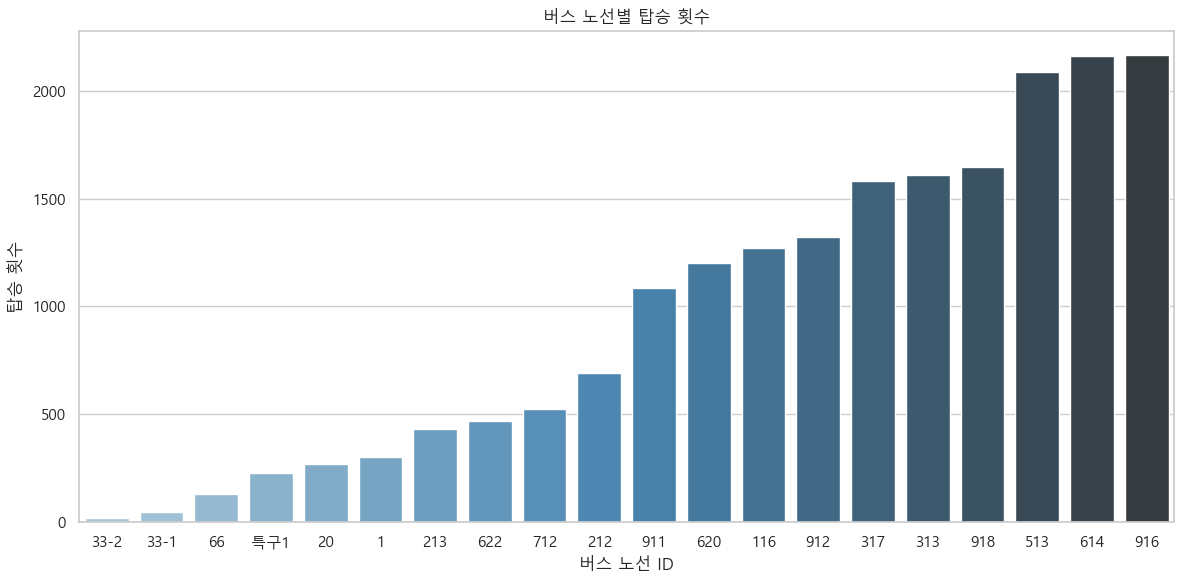

In [63]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style="whitegrid")

plt.figure(figsize=(12, 6))
plt.rc('font',family='malgun gothic')
sns.barplot(x='ROUTE_NO', y='COUNT', data=merged_data, palette='Blues_d')
plt.xlabel('버스 노선 ID')
plt.ylabel('탑승 횟수')
plt.title('버스 노선별 탑승 횟수')
plt.xticks(rotation = 0)
plt.tight_layout()
plt.show()


213, 622, 712, 212, 911

In [72]:
route_30300146 = getstationbyrouteall[getstationbyrouteall['ROUTE_CD']==30300146] # 213번 버스
route_30300144 = getstationbyrouteall[getstationbyrouteall['ROUTE_CD']==30300144] # 622번 버스
route_30300092 = getstationbyrouteall[getstationbyrouteall['ROUTE_CD']==30300092] # 712번 버스
route_30300127 = getstationbyrouteall[getstationbyrouteall['ROUTE_CD']==30300127] # 212번 버스
route_30300094 = getstationbyrouteall[getstationbyrouteall['ROUTE_CD']==30300094] # 911번 버스

In [74]:
import pydeck as pdk
import geopandas as gpd

# 213번 버스 노선 시각화
layer_30300146 = pdk.Layer(
    "ScatterplotLayer",
    data=route_30300146,
    get_position=["GPS_LONG", "GPS_LATI"],
    get_color=[255, 0, 0, 170],  # 빨간색 (RGB 및 투명도)
    get_radius=100,
    pickable=True,
)

# 622번 버스 노선 시각화
layer_30300144 = pdk.Layer(
    "ScatterplotLayer",
    data=route_30300144,
    get_position=["GPS_LONG", "GPS_LATI"],
    get_color=[255, 150, 0, 170],  # 주황색
    get_radius=100,
    pickable=True,
)

# 712번 버스 노선 시각화
layer_30300092 = pdk.Layer(
    "ScatterplotLayer",
    data=route_30300092,
    get_position=["GPS_LONG", "GPS_LATI"],
    get_color=[255, 200, 0, 170],  # 노란색
    get_radius=100,
    pickable=True,
)

# 212번 버스 노선 시각화
layer_30300127 = pdk.Layer(
    "ScatterplotLayer",
    data=route_30300127,
    get_position=["GPS_LONG", "GPS_LATI"],
    get_color=[0, 100, 50, 170],   # 초록색
    get_radius=100,
    pickable=True,
)

# 911번 버스 노선 시각화
layer_30300094 = pdk.Layer(
    "ScatterplotLayer",
    data=route_30300094,
    get_position=["GPS_LONG", "GPS_LATI"],
    get_color=[0, 50, 200, 170],  # 파란색
    get_radius=100,
    pickable=True,
)


# PyDeck 맵 생성
view_state = pdk.ViewState(latitude=36.35, longitude=127.38, zoom=11)
r = pdk.Deck(layers=[layer_30300146, layer_30300144,layer_30300092,layer_30300127,layer_30300094], initial_view_state=view_state)

r.to_html('under5_route.html')
